# Week 36 - Descriptive Statistics and Binary Rule-Based Classifier

## 1. Setup

### 1.1. Libraries

#### 1.1.1. New Libraries

In [ ]:
# new libraries for Google Colab
!pip3 install nltk
!pip3 install datasets
!pip install bnlp-toolkit

#### 1.1.2. Load Libraries

In [ ]:
from datasets import load_dataset                       # library to import data from huggingface
import pandas as pd                                     # library to transform to dataframe. helps for statistics
from nltk.corpus import stopwords                       # library with nlp toolkits, such as lists with stopwords
import string                                           # library with puntuation
from bnlp import BasicTokenizer                         # library for bengali tokenizer
from nltk.tokenize import word_tokenize                 # library for tokenize arabic and indonesian
import numpy as np                                      # library for math operations and matrices
import seaborn as sns                                   # library for making plots
from sklearn.metrics import classification_report       # classification report binary clasiffier
from sklearn.metrics import f1_score, accuracy_score    # f1_score, accuracy

### 1.2. Data

#### 1.2.1. Read Data

In [ ]:
# load training dataset
datasets_train = load_dataset("copenlu/answerable_tydiqa", split='train')
# load validation dataset
datasets_val = load_dataset("copenlu/answerable_tydiqa", split='validation')

In [ ]:
# Stop-words for each language to see differences with and without them
arabic_stopwords = set(stopwords.words("arabic"))
arabic_stopwords.update(string.punctuation)

bengali_stopwords = set(stopwords.words("bengali"))
bengali_stopwords.update(string.punctuation)

indonesian_stopwords = set(stopwords.words("indonesian"))
indonesian_stopwords.update(string.punctuation)

In [ ]:
# Bengali Tolkenizer
bengali_tokenizer = BasicTokenizer()

#### 1.2.2. Transform Data

In [ ]:
# define languages for the project
languages = ['arabic', 'bengali','indonesian']

# transform to pandas dataframe
pandas_datasets_train = pd.DataFrame(datasets_train)
pandas_datasets_val = pd.DataFrame(datasets_val)

# filter languaje
df_train_filter = pandas_datasets_train[pandas_datasets_train['language'].isin(languages)]
df_val_filter = pandas_datasets_val[pandas_datasets_val['language'].isin(languages)]

## 2. Descriptive Statistics

### 2.1. General Statistics

In [ ]:
def oracle(df_list_annotations = []):
  """Check whether a question has an answer"""
  return [0 if x['answer_text'][0] == '' else 1 for x in df_list_annotations]

# oracle function to check whether the question has an answer or not
df_train_filter.loc[:,'answerable_dummy'] = oracle(df_train_filter['annotations'].to_list())
df_val_filter.loc[:,'answerable_dummy'] = oracle(df_val_filter['annotations'].to_list())

# tokens documents
df_train_filter['tokens_document'] = np.where(df_train_filter['language'].isin(['indonesian','arabic']),
         df_train_filter.document_plaintext.apply(lambda x: word_tokenize(x)),
         df_train_filter.document_plaintext.apply(lambda x: bengali_tokenizer(x)))
df_train_filter['tokens_document_len'] = df_train_filter['tokens_document'].apply(lambda x: len(x))

df_val_filter['tokens_document'] = np.where(df_val_filter['language'].isin(['indonesian','arabic']),
         df_val_filter.document_plaintext.apply(lambda x: word_tokenize(x)),
         df_val_filter.document_plaintext.apply(lambda x: bengali_tokenizer(x)))
df_val_filter['tokens_document_len'] = df_val_filter['tokens_document'].apply(lambda x: len(x))


# tokens question
df_train_filter['tokens_question'] = np.where(df_train_filter['language'].isin(['indonesian','arabic']),
         df_train_filter.question_text.apply(lambda x: word_tokenize(x)),
         df_train_filter.question_text.apply(lambda x: bengali_tokenizer(x)))
df_train_filter['tokens_question_len'] = df_train_filter['tokens_question'].apply(lambda x: len(x))

df_val_filter['tokens_question'] = np.where(df_val_filter['language'].isin(['indonesian','arabic']),
         df_val_filter.question_text.apply(lambda x: word_tokenize(x)),
         df_val_filter.question_text.apply(lambda x: bengali_tokenizer(x)))
df_val_filter['tokens_question_len'] = df_val_filter['tokens_question'].apply(lambda x: len(x))


# tokens answer
df_train_filter['tokens_answer'] = np.where(df_train_filter['language'].isin(['indonesian','arabic']),
         df_train_filter['annotations'].apply(lambda x: x['answer_text'][0]).apply(lambda x: word_tokenize(x)),
         df_train_filter['annotations'].apply(lambda x: x['answer_text'][0]).apply(lambda x: bengali_tokenizer(x)))
df_train_filter['tokens_answer_len'] = df_train_filter['tokens_answer'].apply(lambda x: len(x))

df_val_filter['tokens_answer'] = np.where(df_val_filter['language'].isin(['indonesian','arabic']),
         df_val_filter['annotations'].apply(lambda x: x['answer_text'][0]).apply(lambda x: word_tokenize(x)),
         df_val_filter['annotations'].apply(lambda x: x['answer_text'][0]).apply(lambda x: bengali_tokenizer(x)))
df_val_filter['tokens_answer_len'] = df_val_filter['tokens_answer'].apply(lambda x: len(x))

In [ ]:
df_train_filter_summary = df_train_filter.groupby('language').agg({'answerable_dummy':np.sum,
                                                                   'document_title':np.size,
                                                                   'tokens_document_len':np.mean,
                                                                   'tokens_question_len':np.mean,
                                                                   'tokens_answer_len':np.mean,
                                                                   }).reset_index()
df_train_filter_summary.columns = ['language','number_answerable','number_documents','tokens_document_len','tokens_question_len','tokens_answer_len']
df_train_filter_summary['pct_answerable'] = df_train_filter_summary['number_answerable']/df_train_filter_summary['number_documents']
df_train_filter_summary

,language,number_answerable,number_documents,tokens_document_len,tokens_question_len,tokens_answer_len,pct_answerable
0,arabic,14805,29598,89.448848,5.770964,2.817454,0.500203
1,bengali,2390,4779,99.130362,8.184976,1.190416,0.500105
2,indonesian,5702,11394,87.857206,6.168246,2.710023,0.500439


In [ ]:
df_val_filter_summary = df_val_filter.groupby('language').agg({'answerable_dummy':np.sum,
                                                                   'document_title':np.size,
                                                                   'tokens_document_len':np.mean,
                                                                   'tokens_question_len':np.mean,
                                                                   'tokens_answer_len':np.mean,
                                                                   }).reset_index()
df_val_filter_summary.columns = ['language','number_answerable','number_documents','tokens_document_len','tokens_question_len','tokens_answer_len']
df_val_filter_summary['pct_answerable'] = df_val_filter_summary['number_answerable']/df_val_filter_summary['number_documents']
df_val_filter_summary

,language,number_answerable,number_documents,tokens_document_len,tokens_question_len,tokens_answer_len,pct_answerable
0,arabic,951,1902,79.927971,5.651945,2.893270,0.500000
1,bengali,112,224,99.281250,8.571429,1.334821,0.500000
2,indonesian,597,1191,84.486146,6.470193,2.668346,0.501259


### 2.2. Most Frequent Words

In [ ]:
def function_count_words(list_tokens = []):
  """
  Funtion that counts frecuency of words in a list
  """
  token_count = {}
  for token_i in list_tokens:
    if token_i in token_count.keys():
      token_count[token_i] += 1
    else:
      token_count[token_i] = 1
  return token_count

In [ ]:
dict_stopwords = {'arabic':arabic_stopwords,'bengali':bengali_stopwords,'indonesian':indonesian_stopwords}

for language in languages:
  list_documents_tokens = df_train_filter[df_train_filter['language']==language]['tokens_document'].to_list()
  flat_document_tokens = [item for sublist in list_documents_tokens for item in sublist]

  list_questions_tokens = df_train_filter[df_train_filter['language']==language]['tokens_question'].to_list()
  flat_questions_tokens = [item for sublist in list_questions_tokens for item in sublist]

  counts_documents = function_count_words(flat_document_tokens)
  counts_questions = function_count_words(flat_questions_tokens)


  counts_documents_df = pd.DataFrame({'word':counts_documents.keys(),
                'count': counts_documents.values()}).sort_values('count',ascending=False)

  counts_questions_df = pd.DataFrame({'word':counts_questions.keys(),
                'count': counts_questions.values()}).sort_values('count',ascending=False)

  print("#################################################")
  print('5 Most Frequent Words',language,'With StopWords')
  print('Documents')
  print(counts_documents_df.head(5))
  print('Questions')
  print(counts_questions_df.head(5))

  #remove stopwords and english punctuation
  flat_document_tokens_nostop = [word for word in flat_document_tokens if word not in dict_stopwords[language]]
  flat_question_tokens_nostop = [word for word in flat_questions_tokens if word not in dict_stopwords[language]]


  counts_documents = function_count_words(flat_document_tokens_nostop)
  counts_questions = function_count_words(flat_question_tokens_nostop)


  counts_documents_df = pd.DataFrame({'word':counts_documents.keys(),
                'count': counts_documents.values()}).sort_values('count',ascending=False)

  counts_questions_df = pd.DataFrame({'word':counts_questions.keys(),
                'count': counts_questions.values()}).sort_values('count',ascending=False)
  print("#################################################")

  print('5 Most Frequent Words',language,'Without StopWords')
  print('Documents')
  print(counts_documents_df.head(5))
  print('Questions')
  print(counts_questions_df.head(5))
  print("#################################################")


#################################################
5 Most Frequent Words arabic With StopWords
Documents
   word  count
16   في  89705
32    .  88299
22   من  61719
82    [  38120
84    ]  38119
Questions
   word  count
4     ؟  10061
0    ما   7451
11  متى   7130
23   هو   6760
22   من   6309
#################################################
5 Most Frequent Words arabic Without StopWords
Documents
       word  count
1910  تصنيف  15655
90      عام  13640
180       ،  10985
168      ''  10886
166      ``  10034
Questions
    word  count
2      ؟  10061
74   ولد   1564
88   تقع   1540
146   تم   1334
84   عام   1159
#################################################
#################################################
5 Most Frequent Words bengali With StopWords
Documents
   word  count
37    ।  26347
15    ,  12750
14    ]   7123
11    [   7120
8     -   5742
Questions
   word  count
6     ?   4777
56   কী    940
55  নাম    837
11   কত    802
17   হয়    800
##################################

### 2.3. Rule-based Classifier

In [ ]:
def rule_based_proportions(dataset_object):
  """
  proportion of words in the question
  that are in the document
  """
  list_percentage_words_question_documents = []
  for question, document in zip(dataset_object['tokens_question'], dataset_object['tokens_document']):
    size_question = len(question)
    number_question_match_document = sum([1 for x in question if x in document])
    percentage = number_question_match_document/size_question
    list_percentage_words_question_documents.append(percentage)
  return list_percentage_words_question_documents

In [ ]:
df_train_filter['percentage_words_question_document'] = rule_based_proportions(df_train_filter)

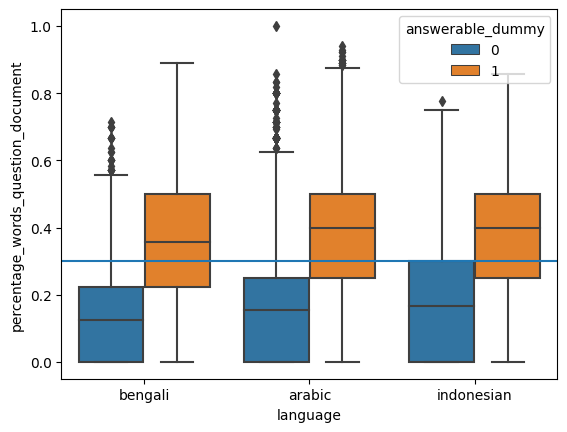

In [ ]:
treshold_ = 0.3
graph = sns.boxplot(y='percentage_words_question_document',hue='answerable_dummy',x='language',data=df_train_filter)
graph.axhline(treshold_)

In [ ]:
def rule_classifier(treshold = treshold_, df_ = pd.DataFrame()):
  """classify according to the proportion of words in the question that matches the document"""
  df_['answeable_predict'] = np.where(df_['percentage_words_question_document']>=treshold,1,0)
  return df_

df_val_filter['percentage_words_question_document'] = rule_based_proportions(df_val_filter)
df_val_filter_rulebase_classifier = rule_classifier(treshold = treshold_, df_= df_val_filter)

In [ ]:
for language in languages:
  df_language_test = df_val_filter_rulebase_classifier[df_val_filter_rulebase_classifier['language']==language]

  print("############################################################ \n",
        language,"\n",
        classification_report(y_true = df_language_test['answerable_dummy'],
                        y_pred = df_language_test['answeable_predict'],
                        target_names=['answerable', 'non-answerable']),"\n",
        f"""The F1 score is: {f1_score(y_true = df_language_test['answerable_dummy'],
                        y_pred = df_language_test['answeable_predict'])}""",
        f"""The accuracy is: {accuracy_score(y_true = df_language_test['answerable_dummy'],
                        y_pred = df_language_test['answeable_predict'])}"""


        )

############################################################ 
 arabic 
                 precision    recall  f1-score   support

    answerable       0.70      0.82      0.76       951
non-answerable       0.78      0.66      0.71       951

      accuracy                           0.74      1902
     macro avg       0.74      0.74      0.74      1902
  weighted avg       0.74      0.74      0.74      1902
 
 The F1 score is: 0.7140401146131805 The accuracy is: 0.7376445846477392
############################################################ 
 bengali 
                 precision    recall  f1-score   support

    answerable       0.67      0.82      0.74       112
non-answerable       0.77      0.60      0.67       112

      accuracy                           0.71       224
     macro avg       0.72      0.71      0.71       224
  weighted avg       0.72      0.71      0.71       224
 
 The F1 score is: 0.6733668341708542 The accuracy is: 0.7098214285714286
#############################